In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd
import torch.distributions as dist

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

from rebar import g, g_tilde, g_lmbda, H, sigma, log_likelihood_bern

import torch
import torch.nn as nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sns.set_style("whitegrid")

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<Axes: ylabel='Count'>

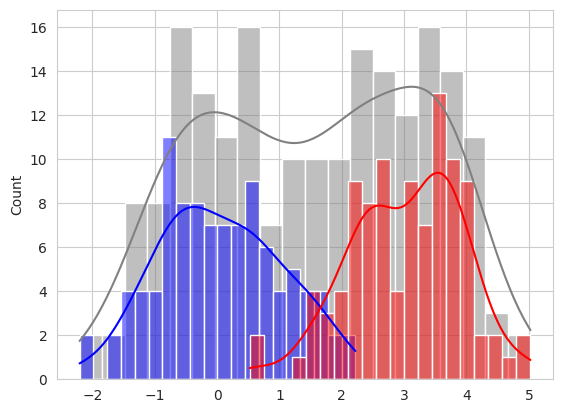

In [3]:
Xs = torch.concatenate([
    torch.randn(100),
    torch.randn(100) + 3,
]).reshape(-1, 1)

sns.histplot(Xs[:, 0], bins=20, kde=True, color='gray', alpha=0.5)
sns.histplot(Xs[:100, 0], bins=20, kde=True, color='blue', alpha=0.5)
sns.histplot(Xs[100:, 0], bins=20, kde=True, color='red', alpha=0.5)

In [4]:
class GMM(nn.Module):
    def __init__(self, mu=None, log_sigma=None):
        super().__init__()
        
        if mu is None:
            self.mu = nn.Parameter(torch.randn(2))
        else:
            self.mu = nn.Parameter(mu)
        
        if log_sigma is None:
            self.log_sigma = nn.Parameter(torch.randn(2))
        else:
            self.log_sigma = nn.Parameter(log_sigma)

        # Decide whether priors are fixed or not
        # self.logits = nn.Parameter(torch.zeros(2))
        self.register_buffer('logits', torch.tensor([0.0, 0.0]))
    
    def get_component_probs(self, x):
        dist0 = dist.Normal(self.mu[0], self.log_sigma[0].exp())
        dist1 = dist.Normal(self.mu[1], self.log_sigma[1].exp())
        
        log_probs = torch.stack([
            dist0.log_prob(x.squeeze()),
            dist1.log_prob(x.squeeze())
        ], dim=1)
        
        log_probs += torch.log_softmax(self.logits, dim=0)
        return log_probs
    
    def forward(self, x):
        log_probs = self.get_component_probs(x)
        log_prob = torch.logsumexp(log_probs, dim=1)
        return -log_prob.mean()

    def classify(self, x):
        log_probs = self.get_component_probs(x)
        return torch.softmax(log_probs, dim=1)

mu_start = [0.5, 1.5]
sigma_start = [-0.1, 0.5]

In [5]:
def create_objective(model):
    def objective(b):
        mu0, mu1 = model.mu[0], model.mu[1]
        sigma0 = model.log_sigma[0].exp()
        sigma1 = model.log_sigma[1].exp()
        
        dist0 = dist.Normal(mu0, sigma0)
        dist1 = dist.Normal(mu1, sigma1)
        
        log_p0 = dist0.log_prob(Xs.squeeze())
        log_p1 = dist1.log_prob(Xs.squeeze())
        
        selected_log_probs = torch.where(b > 0.5, log_p1, log_p0)
        
        return -selected_log_probs.mean()
    
    return objective

# REINFORCE

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:07<00:00, 71.11it/s] 


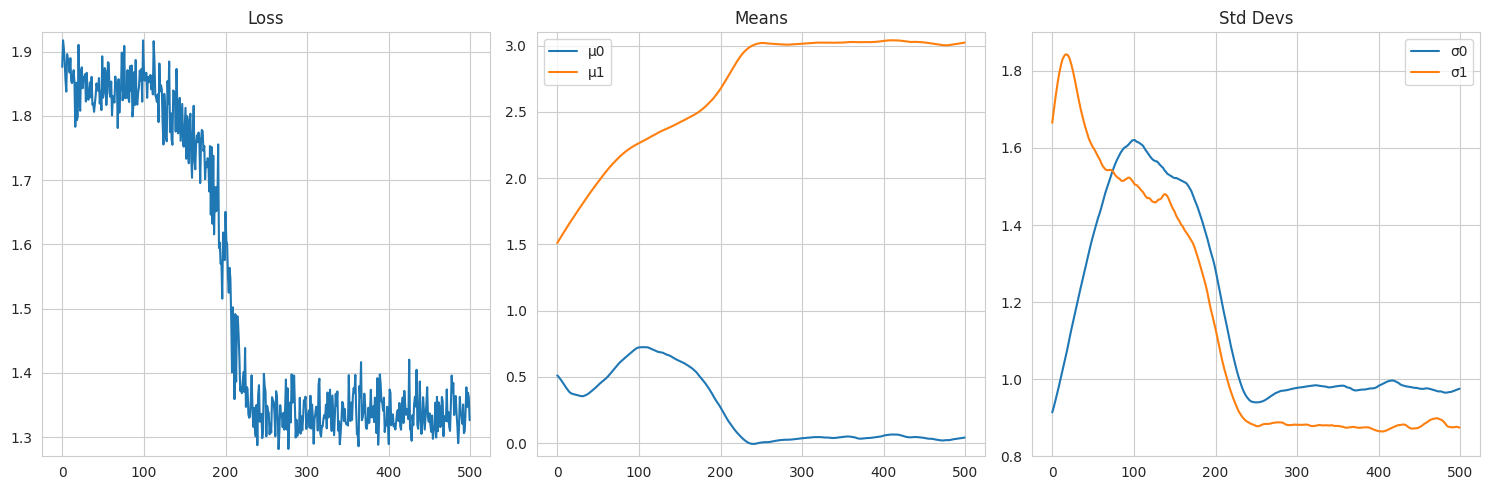

In [15]:
model = GMM(mu=torch.tensor(mu_start), log_sigma=torch.tensor(sigma_start))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.99999))

f = create_objective(model)

n_epochs = 500
n_grad_samples = 8
losses = []
means = []
stds = []
reinforce_grad_variances = []

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    
    all_grad_samples = []
    
    for _ in range(n_grad_samples):
        thetas = model.classify(Xs)
        b = torch.bernoulli(thetas[:, 1]).to(torch.int32)
        loss = f(b.float()).mean().detach()
        action_log_probs = torch.log(thetas[torch.arange(len(Xs)), b] + 1e-8)
        
        reinforce_loss = (loss.detach() * action_log_probs).mean()

        grad = torch.autograd.grad(reinforce_loss, thetas)[0]
        all_grad_samples.append(grad.detach())
    
    if all_grad_samples:
        stacked_grads = torch.stack(all_grad_samples)
        total_variance = torch.var(stacked_grads).item()
    else:
        total_variance = 0.0
    
    reinforce_grad_variances.append(total_variance)
    
    thetas = model.classify(Xs)
    b = torch.bernoulli(thetas[:, 1]).to(torch.int32)
    loss = f(b.float()).mean()
    action_log_probs = torch.log(thetas[torch.arange(len(Xs)), b] + 1e-8)
    reinforce_loss = (loss.detach() * action_log_probs).mean()
    total_loss = loss + reinforce_loss
    
    total_loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    means.append(model.mu.detach().numpy().copy())
    stds.append(model.log_sigma.exp().detach().numpy().copy())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Loss")
plt.ylim([1.27, 1.93])

plt.subplot(1, 3, 2)
plt.plot(np.array(means)[:, 0], label="μ0")
plt.plot(np.array(means)[:, 1], label="μ1")
plt.title("Means")
plt.legend()
plt.ylim([-0.1, 3.1])

plt.subplot(1, 3, 3)
plt.plot(np.array(stds)[:, 0], label="σ0")
plt.plot(np.array(stds)[:, 1], label="σ1")
plt.title("Std Devs")
plt.legend()
plt.ylim([0.8, 1.9])

plt.tight_layout()
plt.show()


# REBAR

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:45<00:00, 10.96it/s]


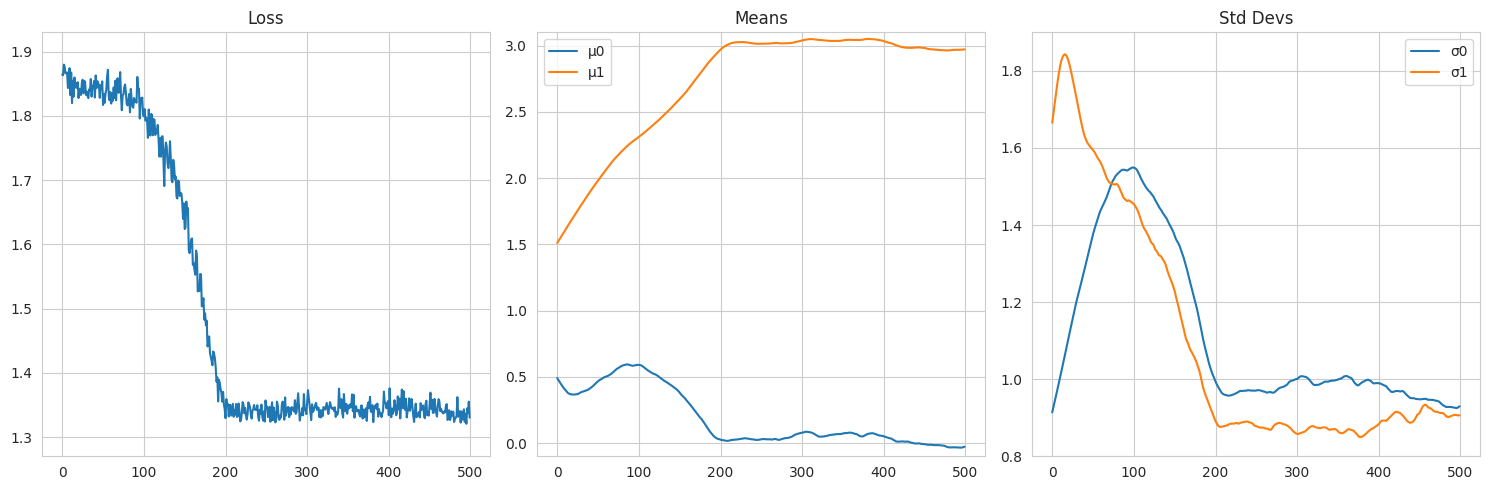

In [18]:
n_epochs = 500
losses = []
means = []
stds = []
lmbda_values = []
eta_values = []
rebar_grad_variances = []

lmbda = torch.tensor([0.1], requires_grad=True)
eta = torch.tensor([0.5], requires_grad=True)

model = GMM(mu=torch.tensor(mu_start), log_sigma=torch.tensor(sigma_start))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.99999))
optimizer_2 = torch.optim.Adam([eta, lmbda], lr=0.05, betas=(0.9, 0.99999))

f = create_objective(model)
n_variance_samples = 8

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    optimizer_2.zero_grad()
    
    grad_samples = []
    
    for _ in range(n_variance_samples):
        with torch.enable_grad():
            thetas = model.classify(Xs)
            u = torch.rand(Xs.shape[0], 1) + 1e-9
            v = torch.rand(Xs.shape[0], 1) + 1e-9
            z = g(u, thetas[:, 1])
            b = H(z).detach()
            z_tilde = g_lmbda(v, thetas[:, 1], lmbda)

            f_b = f(b)
            f_z_tilde = f(sigma(z_tilde, lmbda))
            f_z = f(sigma(z, lmbda))
            
            reinforce_term = (f_b - eta*f_z_tilde.detach()) * log_likelihood_bern(b, thetas[:, 1])
            pathwise_term = eta * (f_z - f_z_tilde)
            rebar_loss = (reinforce_term + pathwise_term).mean()
            
            grad = torch.autograd.grad(
                rebar_loss, thetas,
                retain_graph=False,
                create_graph=False,
                allow_unused=True
            )[0]
            grad_samples.append(grad.detach())
    
    if grad_samples:
        rebar_var = torch.var(torch.stack(grad_samples), dim=0).mean().item()
    else:
        rebar_var = 0.0
    rebar_grad_variances.append(rebar_var)

    with torch.enable_grad():
        thetas = model.classify(Xs)[:, 1]

        temp_thetas = thetas.detach().clone()
        temp_thetas.requires_grad = True

        u = torch.rand(Xs.shape[0], 1) + 1e-9
        v = torch.rand(Xs.shape[0], 1) + 1e-9
        z = g(u, temp_thetas)
        b = H(z).detach()
        z_tilde = g_lmbda(v, temp_thetas, lmbda)

        f_b = f(b)
        f_z_tilde = f(sigma(z_tilde.detach(), lmbda))
        f_z = f(sigma(z, lmbda))
        
        reinforce_term = (f_b - eta*f_z_tilde) * log_likelihood_bern(b, temp_thetas)
        pathwise_term = eta * (f_z - f_z_tilde)
        rebar_loss = (reinforce_term + pathwise_term).mean()
        
        loss = f_b.mean()
        total_loss = loss + rebar_loss

        # Compute partial gradients
        total_loss.backward(create_graph=True, retain_graph=True)
        # Compute gradients for eta and lmbda
        eta.grad, lmbda.grad = torch.autograd.grad(torch.mean(temp_thetas.grad ** 2), (eta,lmbda), allow_unused=True)
        # Propagate the rest of the gradients
        autograd.backward(thetas, temp_thetas.grad.detach())
    
    optimizer.step()
    optimizer_2.step()
    
    with torch.no_grad():
        eta.data.clamp_(0.001, 0.999)
        lmbda.data.clamp_min_(0.001)
    
    losses.append(loss.item())
    lmbda_values.append(lmbda.item())
    eta_values.append(eta.item())
    means.append(model.mu.detach().numpy().copy())
    stds.append(model.log_sigma.exp().detach().numpy().copy())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Loss")
plt.ylim([1.27, 1.93])

plt.subplot(1, 3, 2)
plt.plot(np.array(means)[:, 0], label="μ0")
plt.plot(np.array(means)[:, 1], label="μ1")
plt.title("Means")
plt.legend()
plt.ylim([-0.1, 3.1])

plt.subplot(1, 3, 3)
plt.plot(np.array(stds)[:, 0], label="σ0")
plt.plot(np.array(stds)[:, 1], label="σ1")
plt.title("Std Devs")
plt.legend()
plt.ylim([0.8, 1.9])

plt.tight_layout()
plt.show()


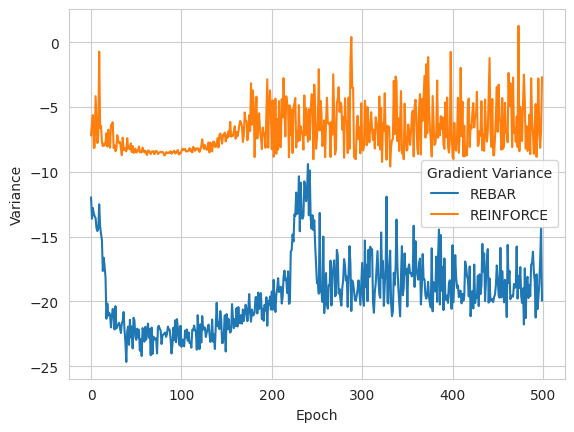

In [13]:
sns.lineplot(data=np.log(rebar_grad_variances), label='REBAR')
sns.lineplot(data=np.log(reinforce_grad_variances), label='REINFORCE')

plt.legend(title='Gradient Variance')
plt.xlabel('Epoch')
plt.ylabel('Variance')

plt.show()